# Calibrate Camera

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from util import *

image_loc = 'camera_cal/calibration*.jpg'
test_imgs = glob.glob('test_images/*.jpg')

In [2]:
mtx, dist, img = calibrate_camera(image_loc)
print(np.array(mtx).shape)
print(np.array(dist).shape)

(3, 3)
(1, 5)


(4, 1, 2)


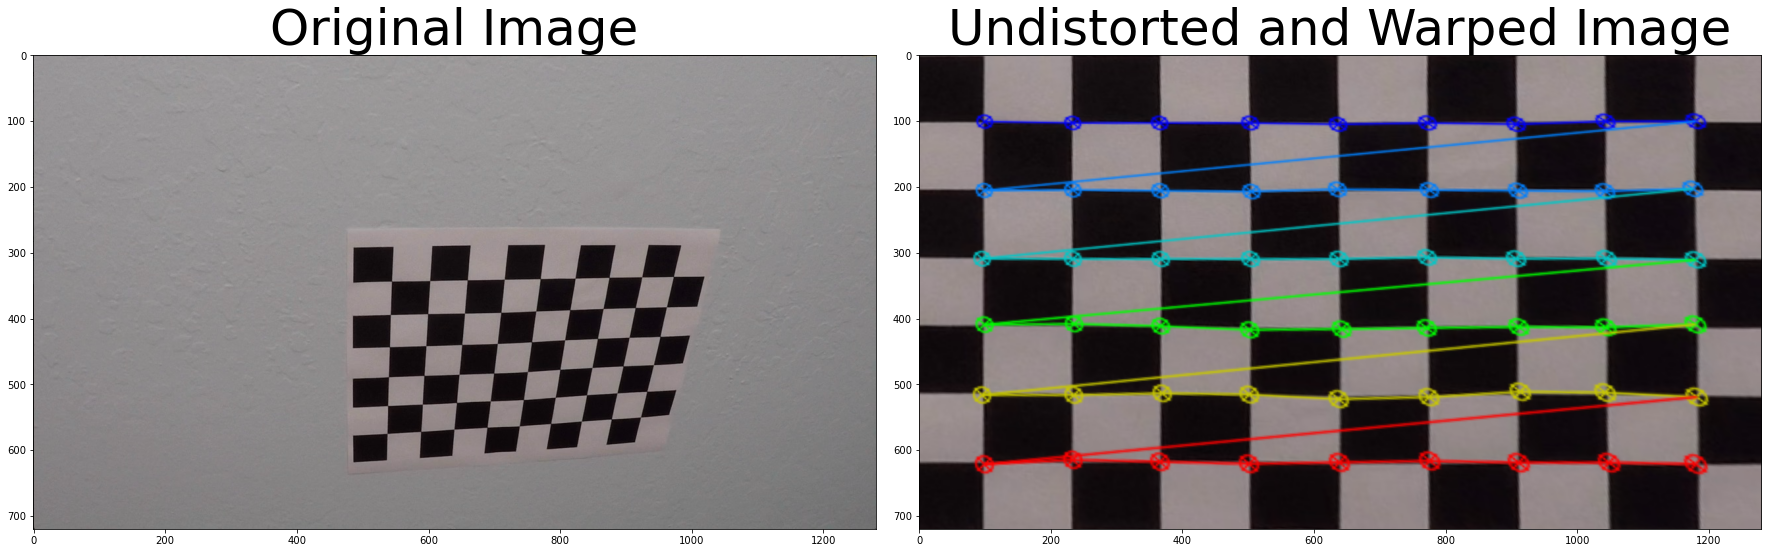

In [3]:
nx = 9
ny = 6
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

True

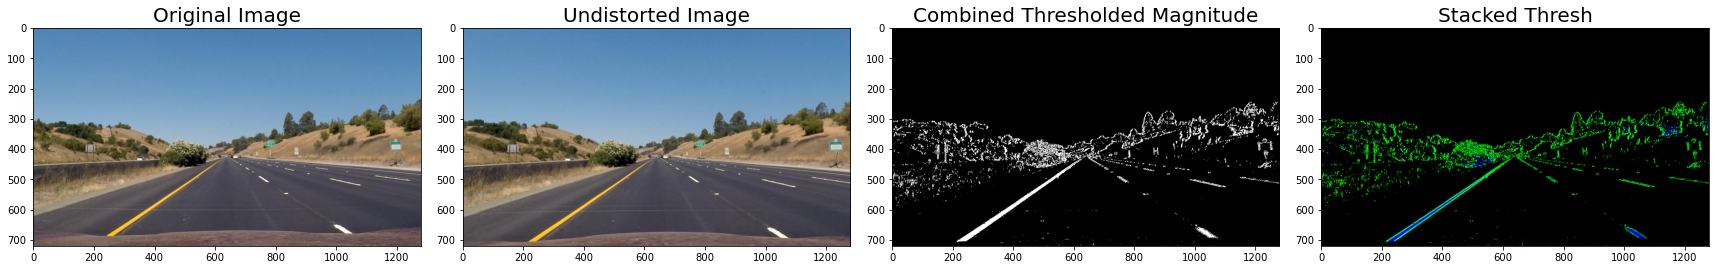

In [4]:
img = cv2.imread(test_imgs[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undist_img = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('examples/undistort_output.png', undist_img)

# mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
color_binary, combined_binary = edgefinding(undist_img)
# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=20)
ax3.imshow(combined_binary,cmap='gray')
ax3.set_title('Combined Thresholded Magnitude', fontsize=20)
ax4.imshow(color_binary)
ax4.set_title('Stacked Thresh', fontsize=20)
cv2.imwrite('examples/binary_combo_example.png', combined_binary)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

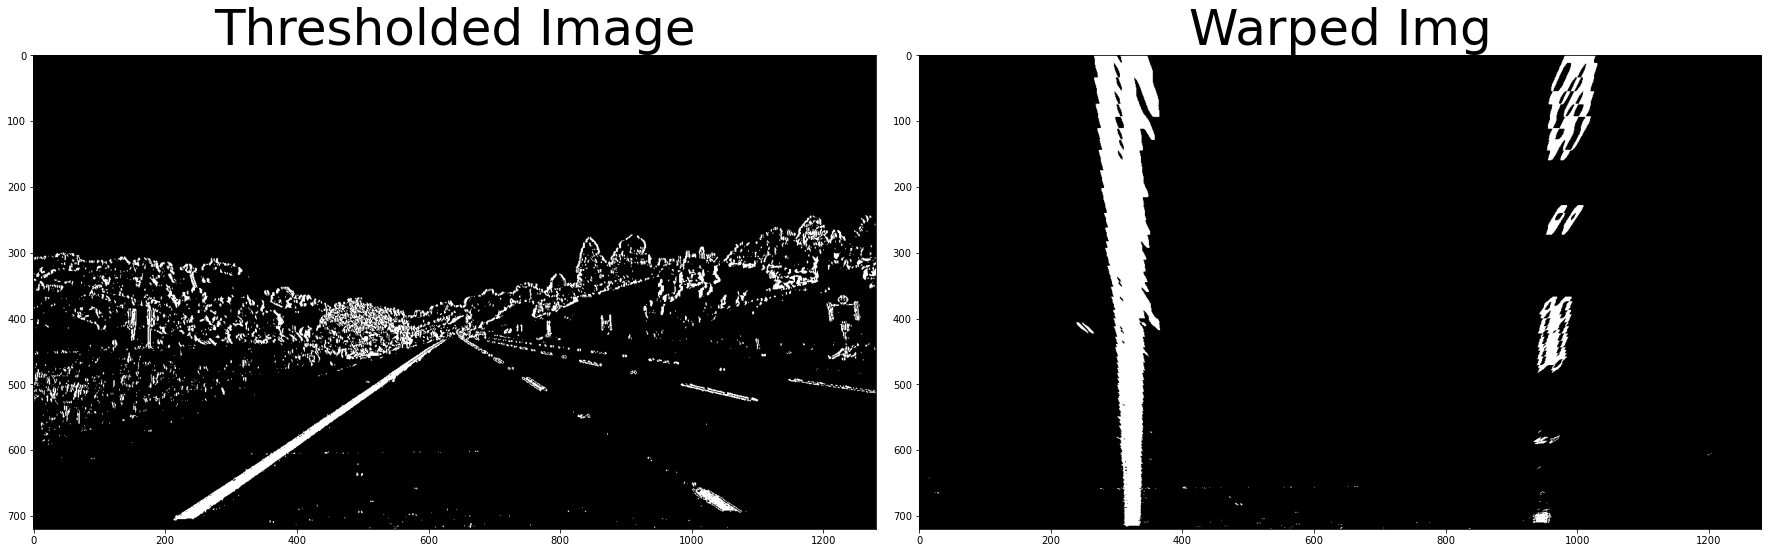

In [5]:
imshape = img.shape

src = np.float32([(200,imshape[0]), (585, 460), (695, 460), (1127,imshape[0])])
dst = np.float32([(320,imshape[0]), (320, 0), (960, 0), (960,imshape[0])])
src = np.expand_dims(src,1)
dst = np.expand_dims(dst,1)
warped, M, Minv = warp(combined_binary, src, dst)



# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Thresholded Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
cv2.imwrite('examples/warped_straight_lines.png', warped)
ax2.set_title('Warped Img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

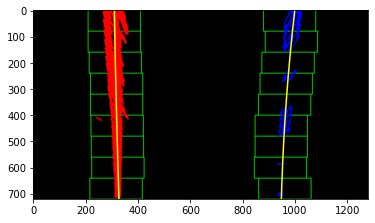

In [6]:
out_img, left_fit, right_fit , x_lv, x_rv = fit_polynomial(warped)

ploty = np.linspace(0, imshape[0]-1, imshape[0])
plt.plot(x_lv, ploty, color='yellow')
plt.plot(x_rv, ploty, color='yellow')
plt.imshow(out_img)

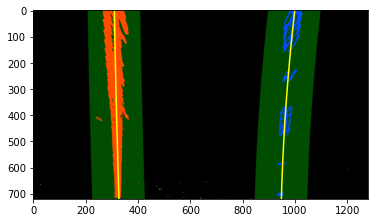

In [7]:

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, x_val = search_around_poly(warped, left_fit, right_fit)

# View your output
plt.plot(x_val[0], ploty, color='yellow')
plt.plot(x_val[1], ploty, color='yellow')
cv2.imwrite('examples/color_fit_lines.png', result)
plt.imshow(result)

In [8]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = get_radius_of_curvature(x_val)

print(left_curverad, 'm', right_curverad, 'm')

15631.096999239171 m 2738.11146043569 m


In [9]:
# Calculate offset in meters
offset_meters = offset(x_val, img)

# Print offset in meters
print(offset_meters)

0.013953481829027786


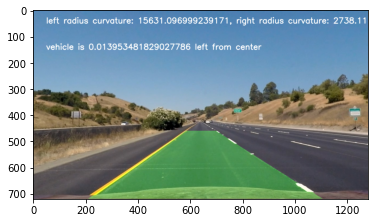

In [10]:
# Draw the lane lines on the original image by unwarping the image    
original_lane_image = original_lane_lines(warped, undist_img, x_val, Minv)
title =  'left radius curvature: {}, right radius curvature: {}'.format(left_curverad, right_curverad)
title1 = 'vehicle is {} left from center'.format(offset_meters)
cv2.putText(original_lane_image, title, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1,  (255, 255, 255), 2, cv2.LINE_AA)
cv2.putText(original_lane_image, title1, (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1,  (255, 255, 255), 2, cv2.LINE_AA)
cv2.imwrite('examples/example_output.jpg', original_lane_image)
plt.imshow(original_lane_image)

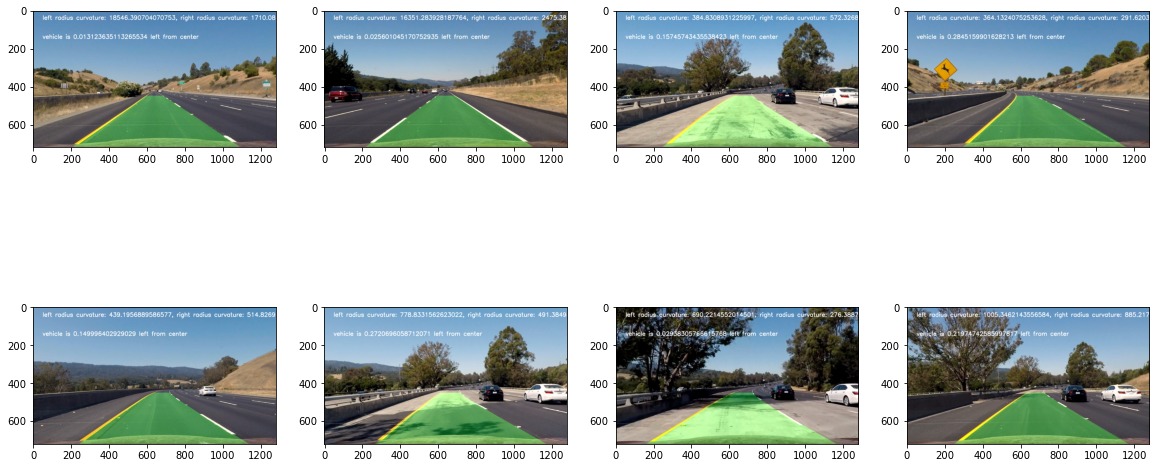

In [11]:
fig = plt.figure(figsize=(20,10))
i = 0

for img_path in test_imgs:
    i += 1
    ax = fig.add_subplot(2, 4, i)
    img = mpimg.imread(img_path)
    name = img_path.split('\\')[1].split('.')[0]
    result = LaneFinder(img, mtx, dist, name)
    ax.imshow(result)

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    output = LaneFinder(image, mtx, dist)
    return output



In [13]:
white_output = 'project_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_out.mp4.
Moviepy - Writing video project_out.mp4



Moviepy - Done !
Moviepy - video ready project_out.mp4
Wall time: 1min 40s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))